## 1. Khai báo thư viện

In [29]:
# Import thư viện cơ bản cho xử lý dữ liệu và hệ thống
import os  # Thao tác với hệ điều hành (đường dẫn, liệt kê file)
import random  # Tạo số ngẫu nhiên (phục vụ tái lập kết quả)
import warnings  # Quản lý cảnh báo khi chạy
from pathlib import Path  # Làm việc với đường dẫn theo kiểu đối tượng

import numpy as np  # Tính toán mảng và ma trận
import pandas as pd  # Xử lý dữ liệu dạng bảng (CSV)
import matplotlib.pyplot as plt  # Vẽ biểu đồ cơ bản
import seaborn as sns  # Vẽ biểu đồ thống kê (đẹp và nhanh)

# Import thư viện âm thanh
import wave  # Đọc thông tin wav theo chuẩn wave
import librosa  # Load và trích xuất đặc trưng âm thanh
import librosa.display  # Hiển thị waveform/spectrogram thuận tiện

# Import TensorFlow / Keras
import tensorflow as tf  # Framework deep learning
from tensorflow.keras import layers, models  # Các lớp và mô hình Keras
from tensorflow.keras.preprocessing import image_dataset_from_directory  # Load ảnh từ thư mục theo class
from tensorflow.keras.applications import MobileNetV2  # Mô hình transfer learning MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input  # Tiền xử lý ảnh đúng chuẩn MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Callback dừng sớm và giảm learning rate
from tensorflow.keras.optimizers import Adam  # Bộ tối ưu Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # Load ảnh và chuyển sang mảng

# Import sklearn
from sklearn.model_selection import train_test_split  # Chia train/validation
from sklearn.metrics import confusion_matrix, classification_report  # Đánh giá mô hình bằng ma trận nhầm lẫn và báo cáo

warnings.filterwarnings('ignore')  # Tắt cảnh báo không cần thiết để notebook gọn

# Thiết lập random seed để tái lập kết quả
SEED = 42  # Giá trị seed cố định
random.seed(SEED)  # Seed cho thư viện random
np.random.seed(SEED)  # Seed cho numpy
tf.random.set_seed(SEED)  # Seed cho tensorflow

print('Đã import thư viện và thiết lập seed thành công.')  # Thông báo hoàn tất

Đã import thư viện và thiết lập seed thành công.


## 7. Load ảnh Mel spectrogram cho CNN

In [ ]:
# Hàm load ảnh từ thư mục và gán nhãn
def load_anh_tu_thu_muc(thu_muc: Path, nhan: int, img_size=(128, 128)):
    X = []
    y = []

    for ten_file in os.listdir(thu_muc):
        if not ten_file.lower().endswith('.png'):
            continue

        path_anh = thu_muc / ten_file
        img = load_img(path_anh, target_size=img_size, color_mode='rgb')
        img_arr = img_to_array(img) / 255.0

        X.append(img_arr)
        y.append(nhan)

    return X, y


img_size = (128, 128)

X_hs_img, y_hs_img = load_anh_tu_thu_muc(thu_muc_anh_mel / 'HS', nhan=0, img_size=img_size)
X_ls_img, y_ls_img = load_anh_tu_thu_muc(thu_muc_anh_mel / 'LS', nhan=1, img_size=img_size)

X = np.array(X_hs_img + X_ls_img)
y = np.array(y_hs_img + y_ls_img)

print('Shape X:', X.shape)
print('Shape y:', y.shape)
print('Phân bố nhãn:', pd.Series(y).value_counts().to_dict())

Shape X: (100, 128, 128, 3)
Shape y: (100,)
Phân bố nhãn: {0: 50, 1: 50}


## 8. Chia train/validation và lưu thành thư mục chuẩn

In [ ]:
# Chia train/validation có stratify
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=SEED,
    stratify=y
)

print('Train:', X_train.shape, y_train.shape)
print('Val  :', X_val.shape, y_val.shape)

Train: (70, 128, 128, 3) (70,)
Val  : (30, 128, 128, 3) (30,)


In [45]:
# Lưu ảnh train/val vào thư mục CNN_dataset
thu_muc_cnn = thu_muc_du_lieu / 'CNN_dataset'  # Thư mục gốc dataset cho CNN
(thu_muc_cnn / 'train' / 'HS').mkdir(parents=True, exist_ok=True)  # Tạo thư mục train/HS
(thu_muc_cnn / 'train' / 'LS').mkdir(parents=True, exist_ok=True)  # Tạo thư mục train/LS
(thu_muc_cnn / 'val' / 'HS').mkdir(parents=True, exist_ok=True)  # Tạo thư mục val/HS
(thu_muc_cnn / 'val' / 'LS').mkdir(parents=True, exist_ok=True)  # Tạo thư mục val/LS

# Hàm lưu ảnh từ numpy array

def luu_anh_tu_numpy(X_subset, y_subset, folder_goc: Path, tien_to: str):  # Hàm lưu một tập ảnh (train hoặc val)
    for i, (img, nhan) in enumerate(zip(X_subset, y_subset)):  # Duyệt qua từng ảnh và nhãn
        ten_lop = 'HS' if nhan == 0 else 'LS'  # Xác định lớp theo nhãn
        path_luu = folder_goc / ten_lop / f'{tien_to}_{i}.png'  # Tạo đường dẫn lưu
        plt.imsave(path_luu, img)  # Lưu ảnh ra file

luu_anh_tu_numpy(X_train, y_train, thu_muc_cnn / 'train', 'train')  # Lưu tập train
luu_anh_tu_numpy(X_val, y_val, thu_muc_cnn / 'val', 'val')  # Lưu tập validation

# Hàm đếm số ảnh trong từng lớp

def dem_anh(folder: Path):  # Hàm đếm số lượng file png ở HS và LS
    dem_hs = len(list((folder / 'HS').glob('*.png')))  # Đếm ảnh HS
    dem_ls = len(list((folder / 'LS').glob('*.png')))  # Đếm ảnh LS
    return dem_hs, dem_ls  # Trả về số lượng

train_hs, train_ls = dem_anh(thu_muc_cnn / 'train')  # Đếm ảnh trong train
val_hs, val_ls = dem_anh(thu_muc_cnn / 'val')  # Đếm ảnh trong validation

print('Train: HS=', train_hs, 'LS=', train_ls, 'Tổng=', train_hs + train_ls)  # In thống kê train
print('Val  : HS=', val_hs, 'LS=', val_ls, 'Tổng=', val_hs + val_ls)  # In thống kê val

Train: HS= 35 LS= 35 Tổng= 70
Val  : HS= 15 LS= 15 Tổng= 30


## 9. Xây dựng mô hình CNN từ đầu

In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

batch_size = 16
img_size_cnn = (128, 128)

train_ds = image_dataset_from_directory(
    thu_muc_cnn / 'train',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=img_size_cnn,
    shuffle=True,
    seed=SEED
)

val_ds = image_dataset_from_directory(
    thu_muc_cnn / 'val',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=img_size_cnn,
    shuffle=False
)

print('Class order:', train_ds.class_names)

Found 70 files belonging to 2 classes.
Found 30 files belonging to 2 classes.
Tên lớp theo thứ tự: ['HS', 'LS']


In [ ]:
# Xây dựng CNN cơ bản
so_lop = 2

cnn_model = models.Sequential([
    layers.Input(shape=(img_size_cnn[0], img_size_cnn[1], 3)),
    data_augmentation,

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(so_lop, activation='softmax')
])

cnn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,585,410 (17.49 MB)

 Trainable params: 4,584,450 (17.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

epochs = 50

lich_su_cnn = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 723ms/step - accuracy: 0.5571 - loss: 1.7251 - val_accuracy: 0.5333 - val_loss: 1.4841 - learning_rate: 1.0000e-04
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 562ms/step - accuracy: 0.7571 - loss: 0.9431 - val_accuracy: 0.3667 - val_loss: 0.9223 - learning_rate: 1.0000e-04
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 485ms/step - accuracy: 0.6857 - loss: 1.0176 - val_accuracy: 0.5667 - val_loss: 0.7771 - learning_rate: 1.0000e-04
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 436ms/step - accuracy: 0.7000 - loss: 1.0449 - val_accuracy: 0.5333 - val_loss: 0.9896 - learning_rate: 1.0000e-04
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 405ms/step - accuracy: 0.7714 - loss: 0.7833 - val_accuracy: 0.5000 - val_loss: 1.1191 - learning_rate: 1.0000e-04
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 403ms/step - accuracy: 0.8286 - loss: 0.3407 - val_accuracy: 0.6667 - val_loss: 0.7506 - learning_rate: 1.0000e-04
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 420ms/step - accuracy: 0.8857 - loss:

## 10. Xây dựng mô hình MobileNetV2 (Transfer Learning)

In [ ]:
# Load lại dataset và preprocess theo chuẩn MobileNetV2
batch_size_mn = 8
img_size_mn = (128, 128)

train_ds_mn = image_dataset_from_directory(
    thu_muc_cnn / 'train',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size_mn,
    image_size=img_size_mn,
    shuffle=True,
    seed=SEED
)

val_ds_mn = image_dataset_from_directory(
    thu_muc_cnn / 'val',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size_mn,
    image_size=img_size_mn,
    shuffle=False
)

train_ds_mn = train_ds_mn.map(lambda x, y: (preprocess_input(x), y))
val_ds_mn = val_ds_mn.map(lambda x, y: (preprocess_input(x), y))

Found 70 files belonging to 2 classes.
Found 30 files belonging to 2 classes.


In [ ]:
# Tạo model MobileNetV2
base_model = MobileNetV2(
    input_shape=(img_size_mn[0], img_size_mn[1], 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

mobilenet_model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(2, activation='softmax')
])

mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train giai đoạn 1 (freeze)
early_stop_mn = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr_mn = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

epochs_mn_1 = 50

lich_su_mn_1 = mobilenet_model.fit(
    train_ds_mn,
    validation_data=val_ds_mn,
    epochs=epochs_mn_1,
    callbacks=[early_stop_mn, reduce_lr_mn]
)

Epoch 1/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 334ms/step - accuracy: 0.4286 - loss: 1.1810 - val_accuracy: 0.5000 - val_loss: 0.9359 - learning_rate: 1.0000e-04
Epoch 2/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5143 - loss: 1.1579 - val_accuracy: 0.5333 - val_loss: 0.8850 - learning_rate: 1.0000e-04
Epoch 3/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.5000 - loss: 1.2517 - val_accuracy: 0.5667 - val_loss: 0.8475 - learning_rate: 1.0000e-04
Epoch 4/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.3857 - loss: 1.0244 - val_accuracy: 0.6333 - val_loss: 0.8077 - learning_rate: 1.0000e-04
Epoch 5/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.4857 - loss: 1.1430 - val_accuracy: 0.6333 - val_loss: 0.7685 - learning_rate: 1.0000e-04
Epoch 6/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.5714 - loss: 0.7943 - val_accuracy: 0.6333 - val_loss: 0.7271 - learning_rate: 1.0000e-04
Epoch 7/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.5857 

In [ ]:
# Fine-tune: mở một phần layer cuối
base_model.trainable = True

so_layer_mo = int(len(base_model.layers) * 0.2)
for layer in base_model.layers[:-so_layer_mo]:
    layer.trainable = False

mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

epochs_mn_2 = 50

lich_su_mn_2 = mobilenet_model.fit(
    train_ds_mn,
    validation_data=val_ds_mn,
    epochs=epochs_mn_2,
    callbacks=[early_stop_mn, reduce_lr_mn]
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step - accuracy: 0.7143 - loss: 0.7181 - val_accuracy: 0.9333 - val_loss: 0.1593 - learning_rate: 1.0000e-05
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.6571 - loss: 0.6814 - val_accuracy: 0.9333 - val_loss: 0.1458 - learning_rate: 1.0000e-05
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.6571 - loss: 0.8129 - val_accuracy: 0.9333 - val_loss: 0.1287 - learning_rate: 1.0000e-05
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.7429 - loss: 0.6089 - val_accuracy: 0.9667 - val_loss: 0.1139 - learning_rate: 1.0000e-05
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.7429 - loss: 0.5526 - val_accuracy: 0.9667 - val_loss: 0.1049 - learning_rate: 1.0000e-05
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.8000 - loss: 0.4026 - val_accuracy: 0.9667 - val_loss: 0.0982 - learning_rate: 1.0000e-05
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.7429 - loss

## 11. Đánh giá mô hình


ĐÁNH GIÁ MÔ HÌNH: CNN cơ bản
Classification report:
              precision    recall  f1-score   support

          HS       0.73      0.73      0.73        15
          LS       0.73      0.73      0.73        15

    accuracy                           0.73        30
   macro avg       0.73      0.73      0.73        30
weighted avg       0.73      0.73      0.73        30



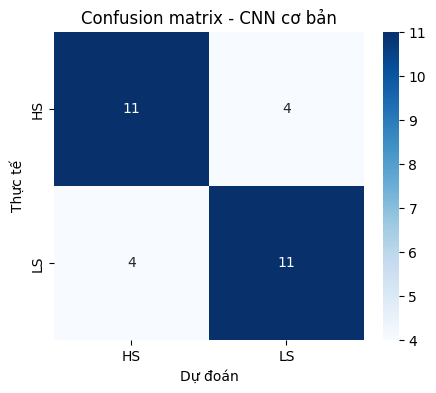


ĐÁNH GIÁ MÔ HÌNH: MobileNetV2
Classification report:
              precision    recall  f1-score   support

          HS       1.00      1.00      1.00        15
          LS       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



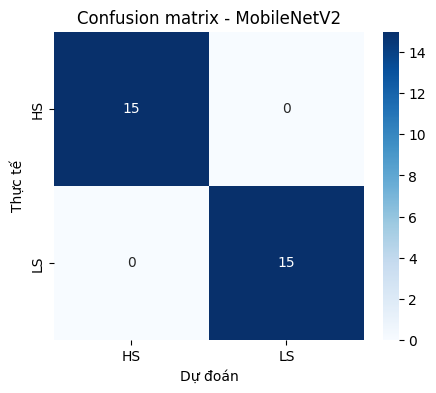

In [ ]:
def danh_gia_mo_hinh(model, dataset, ten_mo_hinh: str):
    y_thuc = []
    y_du_doan = []

    for batch_x, batch_y in dataset:
        du_doan = model.predict(batch_x, verbose=0)
        y_thuc.extend(batch_y.numpy().tolist())
        y_du_doan.extend(np.argmax(du_doan, axis=1).tolist())

    cm = confusion_matrix(y_thuc, y_du_doan)

    print('\n', '=' * 60)
    print('ĐÁNH GIÁ MÔ HÌNH:', ten_mo_hinh)
    print('=' * 60)
    print('Classification report:')
    print(classification_report(y_thuc, y_du_doan, target_names=['HS', 'LS']))

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['HS', 'LS'],
        yticklabels=['HS', 'LS']
    )
    plt.title(f'Confusion matrix - {ten_mo_hinh}')
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.show()


danh_gia_mo_hinh(cnn_model, val_ds, 'CNN cơ bản')
danh_gia_mo_hinh(mobilenet_model, val_ds_mn, 'MobileNetV2')

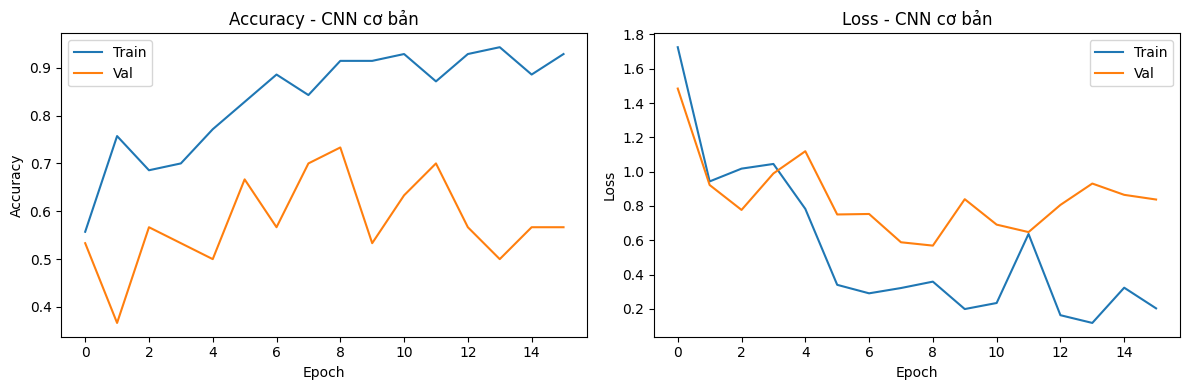

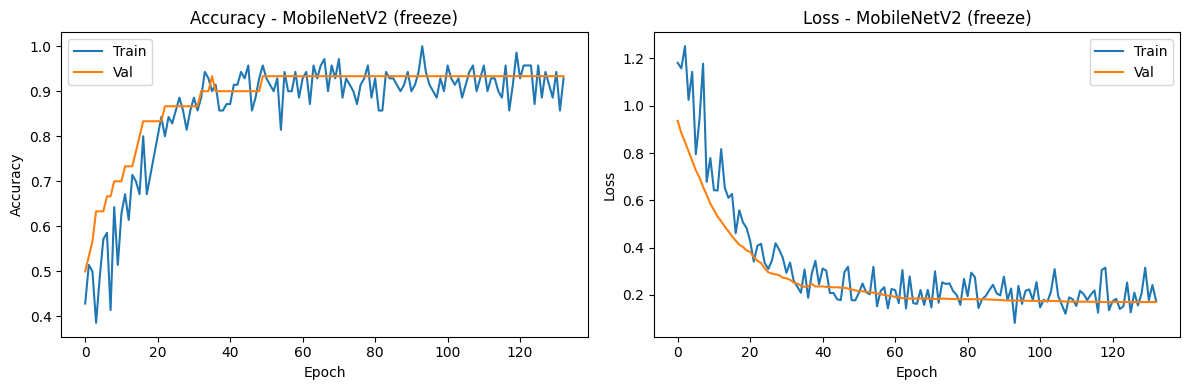

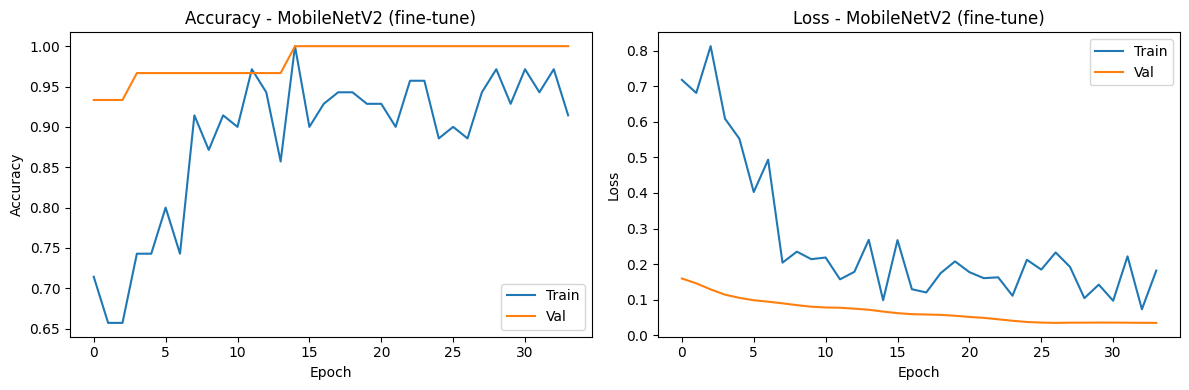

In [ ]:
# Vẽ đồ thị accuracy và loss theo epoch
def ve_do_thi_hoc(history, tieu_de: str):
    if history is None:
        return

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history.get('accuracy', []), label='Train')
    plt.plot(history.history.get('val_accuracy', []), label='Val')
    plt.title('Accuracy - ' + tieu_de)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history.get('loss', []), label='Train')
    plt.plot(history.history.get('val_loss', []), label='Val')
    plt.title('Loss - ' + tieu_de)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


ve_do_thi_hoc(lich_su_cnn, 'CNN cơ bản')
ve_do_thi_hoc(lich_su_mn_1, 'MobileNetV2 (freeze)')
ve_do_thi_hoc(lich_su_mn_2, 'MobileNetV2 (fine-tune)')